# Introduction
We assembled thoracic radiotherapy planning CT scans from 150 patients with locally advanced non-small cell lung cancer at Penn Radiation Oncology for primary GTV segmentation. The dataset is not publicly available.

## Imports
**Task: Import the necessary libraries**

* Pathlib for easy path handling
* nibabel as the files are provided in the NIfTI format
* numpy for data saving and processing
* matplotlib for plotting
* celluloid for nice volume visualization
* tqdm for nice progressing bars
* cv2 for resizing

In [1]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from tqdm.notebook import tqdm
import cv2

## Inspection:
**Task: Define the paths to images and labels for training**

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

from pathlib import Path
import glob

# Base folder shown in your screenshot
BASE = Path("E:/DoNotTouch/projects/LANSCLC/CIS_5810/selected_150_split")

if not BASE.exists():
    raise FileNotFoundError(f"Path not found: {BASE}\n"
                            "Double-check the exact folder names in My Drive.")

splits = ["train", "val", "test"]

def find_niis(root: Path):
    # finds both .nii.gz and .nii
    return list(root.rglob("*.nii.gz")) + list(root.rglob("*.nii"))

for s in splits:
    split_dir = BASE / s
    nii_paths = find_niis(split_dir)
    print(f"{s}: {len(nii_paths)} files")
    for p in nii_paths[:3]:   # show a few examples
        print("  ", p)
    print()

# Optional: pick one file from train to load later
train_files = find_niis(BASE / "train")
if train_files:
    sample_path = train_files[0]
    print("Sample file:", sample_path)

train: 350 files
   E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\train\image\Lung_008_0000.nii.gz
   E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\train\image\Lung_026_0000.nii.gz
   E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\train\image\Lung_029_0000.nii.gz

val: 200 files
   E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\val\image\Lung_036_0000.nii.gz
   E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\val\image\Lung_054_0000.nii.gz
   E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\val\image\Lung_056_0000.nii.gz

test: 200 files
   E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\test\image\Lung_014_0000.nii.gz
   E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\test\image\Lung_038_0000.nii.gz
   E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\test\image\Lung_043_0000.nii.gz

Sample file: E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\train\image\Lung_008_0000.nii.g

In [3]:
images = list((BASE / "train" / "image").rglob("*.nii.gz"))
labels = list((BASE / "train" / "label_gtvp").rglob("*.nii.gz"))
print("train images:", len(images), " | train labels:", len(labels))

train images: 70  | train labels: 70


**Task: Load a sample NIfTI and its corresponding label mask**

In [4]:
from pathlib import Path
import re

def change_img_to_label_path(img_path: Path) -> Path:
    img_path = Path(img_path)
    # swap .../image/... -> .../label_gtvp/...
    label_dir = img_path.parent.parent / "label_gtvp"
    # remove only the FINAL "_0000" before extension
    new_name = re.sub(r'_0000(?=\.nii(\.gz)?$)', '', img_path.name)
    return label_dir / new_name

In [5]:
# images: List[Path]
candidates = [p for p in images if p.name.startswith("Lung")]
if len(candidates) < 3:
    raise IndexError(f"Only {len(candidates)} files match 'Lung*'")
sample_path = candidates[2]   # 3rd match
sample_path_label = change_img_to_label_path(sample_path)

In [6]:
sample_path, sample_path_label

(WindowsPath('E:/DoNotTouch/projects/LANSCLC/CIS_5810/selected_150_split/train/image/Lung_029_0000.nii.gz'),
 WindowsPath('E:/DoNotTouch/projects/LANSCLC/CIS_5810/selected_150_split/train/label_gtvp/Lung_029.nii.gz'))

### Load NIfTI and extract image data

In [7]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata()

**Task: Find out the orientation**

In [8]:
nib.aff2axcodes(data.affine) # In Part 2, I mistakenly planned to use RAS; in Part 3, I’ll correct this to LPS. We’ll only convert to RAS if a specific tool requires it (typically some neuroimaging tools).

('L', 'P', 'S')

**Task: Inspect the loaded data with overlaid Ground Truth tumor segmentation**

<IPython.core.display.Javascript object>


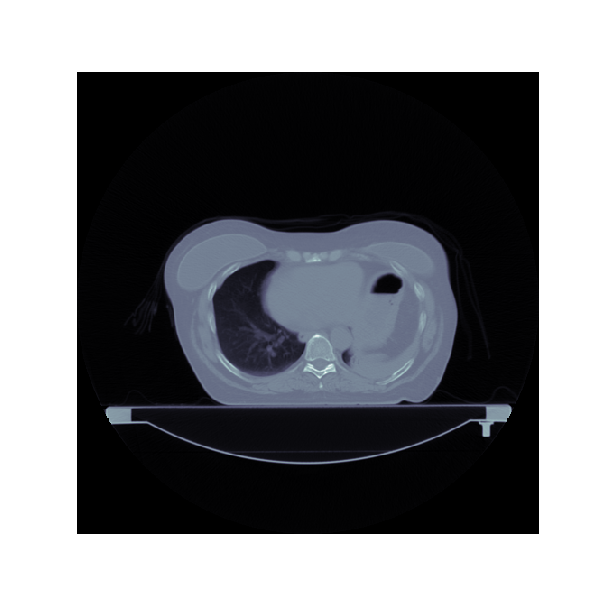

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera

def reorient(slice2d: np.ndarray) -> np.ndarray:
    """Flip vertically, then rotate -90 degrees."""
    s = np.flipud(slice2d)      # flip top/bottom
    s = np.rot90(s, k=3)        # -90° (clockwise)
    return s

fig, ax = plt.subplots(figsize=(6, 6))
camera = Camera(fig)

for i in range(0, ct.shape[2], 2):  # axial slices
    ct_i   = reorient(ct[:, :, i])
    mask_i = reorient(mask[:, :, i])

    ax.imshow(ct_i, cmap="bone", interpolation="nearest")  # origin default 'upper' is fine after our transform
    ax.imshow(np.ma.masked_where(mask_i == 0, mask_i), alpha=0.5,
              cmap="autumn", interpolation="nearest")
    ax.set_axis_off()
    camera.snap()

anim = camera.animate(interval=180, blit=True, repeat=True, repeat_delay=800)

In [10]:
# once in the env:
# pip install imageio-ffmpeg
import matplotlib as mpl, imageio_ffmpeg
mpl.rcParams['animation.ffmpeg_path'] = imageio_ffmpeg.get_ffmpeg_exe()

from IPython.display import HTML
HTML(anim.to_html5_video())

## Preprocessing
**Task: Perform the following preprocessing steps:**

1. CT images have a fixed range from -1000 to 3071. **Thus we normalize by dividing by 3071** <br /> We don't need to compute mean and standard deviation for this task
2. As we want to focus on lung tumors, we can crop away parts of the lower abdomen to reduce the complexity and help the network learn. As an example, **we skip the first 20 slices (from lower abdomen to the neck)** (last axis)
3. As we want to tackle this task on a slice level (2D) and not on a subject level (3D) to reduce the computational cost **we store the preprocessed data as 2d files**, because reading a single slice is much faster than loading the complete NIfTI file.
4. Resize the single slices and masks to (256, 256) (when resizing the mask, pass interpolation=cv2.INTER_NEAREST to the resize function to apply nearest neighbour interpolation)

Loop over all_files and apply the preprocessing steps. <br />

In the preprocessing loop, you need to create a directory for each subject containg the ct and label slices with identical names. <br />
E.g:
* 0/data/0.npy
* 0/masks/0.npy

In [11]:
from pathlib import Path

def collect_pairs(split_dir: Path):
    """Return (image_path, label_path) pairs for a split; warn if a label is missing."""
    img_dir = split_dir / "image"
    img_paths = list(img_dir.rglob("*.nii*"))
    pairs = []
    for ip in img_paths:
        lp = change_img_to_label_path(ip)  # your existing helper
        if lp.exists():
            pairs.append((ip, lp))
        else:
            print(f"WARNING ({split_dir.name}): missing label for {ip.name}")
    return pairs

# Existing base
# BASE = Path("/...")  # already defined earlier

pairs_train = collect_pairs(BASE / "train")
pairs_val   = collect_pairs(BASE / "val")
pairs_test  = collect_pairs(BASE / "test")   # <-- NEW

print(f"Paired counts -> train: {len(pairs_train)} | val: {len(pairs_val)} | test: {len(pairs_test)}")

# If you want a merged list (train+val+test)
pairs_all = pairs_train + pairs_val + pairs_test
print(f"Merged total (train+val+test): {len(pairs_all)}")

# Optional: peek a few from each split
for name, pairs in [("train", pairs_train), ("val", pairs_val), ("test", pairs_test)]:
    print(f"\n{name} preview:")
    for i, (ip, lp) in enumerate(pairs[:3]):
        print(f"  [{i}] img: {ip.name}  |  lbl: {lp.name}")

Paired counts -> train: 70 | val: 40 | test: 40
Merged total (train+val+test): 150

train preview:
  [0] img: Lung_008_0000.nii.gz  |  lbl: Lung_008.nii.gz
  [1] img: Lung_026_0000.nii.gz  |  lbl: Lung_026.nii.gz
  [2] img: Lung_029_0000.nii.gz  |  lbl: Lung_029.nii.gz

val preview:
  [0] img: Lung_036_0000.nii.gz  |  lbl: Lung_036.nii.gz
  [1] img: Lung_054_0000.nii.gz  |  lbl: Lung_054.nii.gz
  [2] img: Lung_056_0000.nii.gz  |  lbl: Lung_056.nii.gz

test preview:
  [0] img: Lung_014_0000.nii.gz  |  lbl: Lung_014.nii.gz
  [1] img: Lung_038_0000.nii.gz  |  lbl: Lung_038.nii.gz
  [2] img: Lung_043_0000.nii.gz  |  lbl: Lung_043.nii.gz


In [12]:
from pathlib import Path
from fnmatch import fnmatch

all_files = [img for (img, lbl) in pairs_all if fnmatch(Path(img).name, "Lung_*")]
print(len(all_files), "matches")

150 matches


In [14]:
from pathlib import Path
import time, shutil
import numpy as np
import nibabel as nib
from tqdm import tqdm
from scipy.ndimage import zoom  # <-- use SciPy resize, not OpenCV
from typing import Tuple


# ====== CONFIG ======
# Assumes you already defined:
#   BASE: Path to your dataset root (Path)
#   all_files: list[Path] of CT NIfTI files
#   change_img_to_label_path: function mapping CT path -> label path
save_root = BASE / "Preprocessed_for_2D_Unet"

TRAIN_N = 70   # first 70 -> train
VAL_N   = 40   # next 40 -> val
# remaining -> test

TARGET_HW = (256, 256)  # (H, W)  <-- use H,W convention for SciPy

# ====== HELPERS ======
def safe_np_save(dest_path: Path, array: np.ndarray, retries: int = 5, sleep: float = 0.5):
    """Atomic-ish save: write a temp .npy next to the target, then move."""
    dest_path = dest_path.with_suffix(".npy")
    dest_path.parent.mkdir(parents=True, exist_ok=True)

    tmp_local = dest_path.parent / (dest_path.stem + ".__tmp__.npy")
    np.save(tmp_local, array)

    last_err = None
    for k in range(retries):
        try:
            shutil.move(str(tmp_local), str(dest_path))
            return
        except Exception as e:
            last_err = e
            time.sleep(sleep * (2 ** k))
    raise OSError(f"Failed to write {dest_path} after {retries} retries") from last_err

def as_img2d(a) -> np.ndarray:
    """Ensure a clean 2D, C-contiguous float32 base ndarray (no subclasses)."""
    a = np.asarray(a, dtype=np.float32).view(np.ndarray)
    a = np.squeeze(a)
    if a.ndim != 2:
        raise ValueError(f"Expected 2D slice, got shape {a.shape}")
    if not a.flags["C_CONTIGUOUS"]:
        a = np.ascontiguousarray(a)
    return a

def scipy_resize2d(img2d: np.ndarray, out_hw: Tuple[int, int], order: int) -> np.ndarray:
    """
    Resize 2D with SciPy ndimage.zoom.
    - out_hw: (H_out, W_out)
    - order: 1 for linear (images), 0 for nearest (masks)
    """
    src = as_img2d(img2d)
    H, W = src.shape
    Ht, Wt = int(out_hw[0]), int(out_hw[1])
    zy = Ht / float(H)
    zx = Wt / float(W)
    # prefilter=False is fine for order 0/1 and faster
    out = zoom(src, (zy, zx), order=order, prefilter=False)
    return out.astype(np.float32, copy=False)

# ====== MAIN ======
save_root.mkdir(parents=True, exist_ok=True)

n_train = n_val = n_test = 0

for counter, path_to_ct_data in enumerate(tqdm(all_files, desc="Preprocessing")):
    path_to_label = change_img_to_label_path(path_to_ct_data)  # may not exist

    # --- Load volumes as float32 base ndarray ---
    ct_img = nib.load(path_to_ct_data)
    ct_vol = np.array(ct_img.get_fdata(dtype=np.float32), dtype=np.float32, copy=False)  # (H,W,D)

    has_label = path_to_label.exists()
    if has_label:
        lbl_img = nib.load(path_to_label)
        lbl_vol = np.array(lbl_img.get_fdata(dtype=np.float32), dtype=np.float32, copy=False)

    # --- Optional depth crop & basic scaling ---
    if ct_vol.shape[-1] > 20:
        ct_vol = ct_vol[:, :, 20:]
        if has_label:
            lbl_vol = lbl_vol[:, :, 20:]

    # Scale HU-ish range if raw HU provided (adjust as you like)
    ct_vol = ct_vol / 3071.0

    # Sanitize numerics
    ct_vol = np.nan_to_num(ct_vol, nan=0.0, posinf=0.0, neginf=0.0)
    if has_label:
        lbl_vol = np.nan_to_num(lbl_vol, nan=0.0, posinf=0.0, neginf=0.0)

    # Ensure there are slices after crop
    D = int(ct_vol.shape[-1])
    if D == 0:
        print(f"[Skip] No slices after crop: {path_to_ct_data}")
        continue

    # --- Decide split ---
    if counter < TRAIN_N:
        split = "train"; n_train += 1
    elif counter < TRAIN_N + VAL_N:
        split = "val";   n_val += 1
    else:
        split = "test";  n_test += 1

    current_path = save_root / split / str(counter)
    data_dir = current_path / "data"
    mask_dir = current_path / "masks"
    data_dir.mkdir(parents=True, exist_ok=True)
    if has_label:
        mask_dir.mkdir(parents=True, exist_ok=True)

    # --- Slice-wise save ---
    for i in range(D):
        slc = scipy_resize2d(ct_vol[:, :, i], TARGET_HW, order=1)   # linear for images
        safe_np_save(data_dir / f"{i}", slc)

        if has_label:
            msk = scipy_resize2d(lbl_vol[:, :, i], TARGET_HW, order=0)  # nearest for masks
            safe_np_save(mask_dir / f"{i}", msk)

print(f"Saved cases -> train: {n_train} | val: {n_val} | test: {n_test}")
print("Output root:", save_root)

Preprocessing: 100%|█████████████████████████████████████████████████████████████████| 150/150 [09:34<00:00,  3.83s/it]

Saved cases -> train: 70 | val: 40 | test: 40
Output root: E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet


# Validate preprocessed data
**Task: Take a look at stored files and inspect if everything worked as expected**

In [19]:
path = BASE / "Preprocessed_for_2D_Unet/train/2"  # Select a subject. Check the folder if it exists

In [20]:
list(path.glob("*"))

[WindowsPath('E:/DoNotTouch/projects/LANSCLC/CIS_5810/selected_150_split/Preprocessed_for_2D_Unet/train/2/data'),
 WindowsPath('E:/DoNotTouch/projects/LANSCLC/CIS_5810/selected_150_split/Preprocessed_for_2D_Unet/train/2/masks')]

In [21]:
file = "36.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

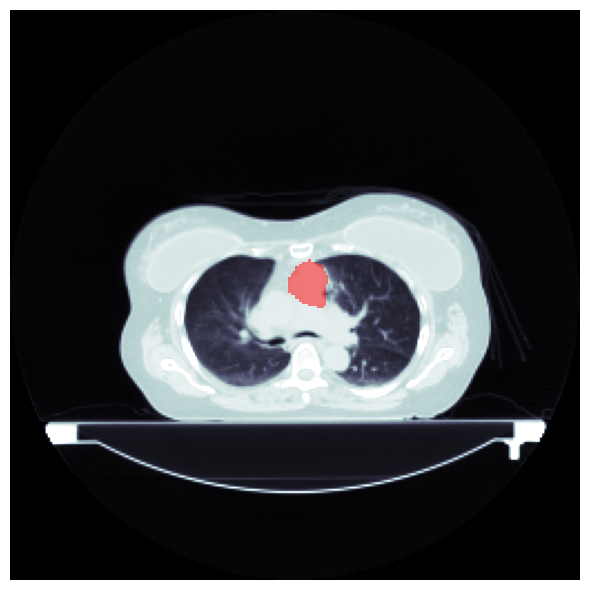

In [22]:
# 1) Ensure inline backend
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

def reorient_2d(a: np.ndarray) -> np.ndarray:
    return np.rot90(np.flipud(a), k=3)  # flip TB, rotate -90° (clockwise)

# slc, msk must be 2D arrays
slc = np.asarray(slice)      # your CT slice
msk = np.asarray(mask)       # your mask (0/1)

# safety checks
assert slc.ndim == 2 and msk.ndim == 2, (slc.shape, msk.shape)
assert slc.shape == msk.shape, "slice/mask shapes must match"

# reorient
slc_r = reorient_2d(slc)
msk_r = reorient_2d(msk)

# robust window
vmin, vmax = np.percentile(slc_r, [1, 99])
if not np.isfinite(vmin) or not np.isfinite(vmax) or vmax <= vmin:
    vmin, vmax = float(np.nanmin(slc_r)), float(np.nanmax(slc_r))

# 2) Make and show the figure (no global close, no clear_output)
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(slc_r, cmap="bone", vmin=vmin, vmax=vmax)
ax.imshow(np.ma.masked_where(msk_r == 0, msk_r), cmap="autumn", alpha=0.5, interpolation="nearest")
ax.axis("off")
fig.tight_layout()
plt.show()            # <-- explicitly show
plt.close(fig)        # close just this figure

In [23]:
print(slice.min(), slice.max())

-0.33344188 0.23823161
